In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras import utils
import tensorflow as tf
from keras import Sequential, models
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, matthews_corrcoef
)

2024-08-23 16:12:00.753024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 16:12:00.794808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 16:12:00.829128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 16:12:00.838117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 16:12:00.864471: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import tensorflow as tf
import gc

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth has been set for GPU.")
    except RuntimeError as e:
        print(e)

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Optionally, delete the model and other variables
#del model

# Force garbage collection
gc.collect()

# If you're using TensorFlow 2.x and want to clear GPU memory, you can reset the context:
tf.config.experimental.reset_memory_stats(device='GPU:0')

print("GPU memory has been cleared.")


Memory growth has been set for GPU.


I0000 00:00:1724422322.574582 4125811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724422322.647205 4125811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724422322.647447 4125811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724422322.845046 4125811 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

GPU memory has been cleared.


### Defining the Modell

In [4]:
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# XRan Dataset

### Load the Datasets

In [5]:
# Load the data
benign_data = pd.read_csv('../datasets/xran/benign/Benign.csv', delimiter=';', low_memory=False)
isot_data = pd.read_csv('../datasets/xran/ransomware/ISOT.csv', delimiter=';', low_memory=False)
sorel20m_data = pd.read_csv('../datasets/xran/ransomware/Sorel20M.csv', delimiter=';', low_memory=False)
virusshare_data = pd.read_csv('../datasets/xran/ransomware/VirusShare.csv', delimiter=';', low_memory=False)

# Function to process and encode sequences
def process_sequences(data, encoder, api_length=500, dll_length=10, mutex_length=10):
    # Extract API calls, DLLs, and Mutexes
    api_calls = data.filter(regex='ApiCall_').values
    dlls = data.filter(regex='Dll_').values
    mutexes = data.filter(regex='Mutex_').values

    # Truncate or pad sequences
    api_calls = [list(row)[:api_length] + [''] * (api_length - len(row)) for row in api_calls]
    dlls = [list(row)[:dll_length] + [''] * (dll_length - len(row)) for row in dlls]
    mutexes = [list(row)[:mutex_length] + [''] * (mutex_length - len(row)) for row in mutexes]

    # Combine sequences
    combined_sequences = [api + dll + mutex for api, dll, mutex in zip(api_calls, dlls, mutexes)]
    
    # Flatten the list of sequences to fit label encoder requirements
    flat_sequences = [item for sublist in combined_sequences for item in sublist]
    
    # Encode the sequences    
    encoded_sequences = encoder.fit_transform(flat_sequences)
    
    # Reshape back to the original structure
    encoded_sequences = np.reshape(encoded_sequences, (len(combined_sequences), api_length + dll_length + mutex_length))
    
    return encoded_sequences, encoder

# Process the datasets
encoder = LabelEncoder()

benign_sequences, encoder = process_sequences(benign_data, encoder)
isot_sequences, _ = process_sequences(isot_data, encoder)
sorel20m_sequences, _ = process_sequences(sorel20m_data, encoder)
virusshare_sequences, _ = process_sequences(virusshare_data, encoder)

# Convert to DataFrame for further use
benign_df = pd.DataFrame(benign_sequences)
isot_df = pd.DataFrame(isot_sequences)
sorel20m_df = pd.DataFrame(sorel20m_sequences)
virusshare_df = pd.DataFrame(virusshare_sequences)

# Add labels
benign_df['label'] = 0
isot_df['label'] = 1
sorel20m_df['label'] = 1
virusshare_df['label'] = 1

In [6]:
benign_df.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,label
0,1638,1638,1638,1638,1638,1638,1638,1638,1638,1638,...,1923,1926,1341,1344,1343,1342,1924,1927,1928,0
1,1638,1638,1638,1638,1638,1638,1638,1638,1638,1638,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
2,639,1231,1232,1232,1232,1232,1232,1232,1232,1232,...,716,706,715,1325,705,711,717,707,708,0
3,1638,1638,1638,1638,1638,1638,1546,1559,1546,625,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
4,639,1546,1559,1546,1231,1232,1232,1232,1232,1231,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0


### Combine the Datasets and shuffel it

In [7]:
# Combine datasets
combined_df = pd.concat([benign_df, isot_df, sorel20m_df, virusshare_df], ignore_index=True)

# Shuffle the combined dataset
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,511,512,513,514,515,516,517,518,519,label
0,8680,8679,8678,3,3,8672,8671,3,3,8683,...,5474,5475,2996,2997,2995,5473,8673,7024,5478,1
1,1930,1233,1232,1232,1232,575,1547,1548,1546,1546,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
2,639,1937,1930,620,620,429,429,429,429,1547,...,2658,2658,2658,2658,2658,2658,2658,2658,2658,0
3,285,2194,2209,2194,1980,1981,1981,1981,1981,1980,...,2625,2625,2625,2625,2625,2625,2625,2625,2625,1
4,8680,8679,8678,3,3,8672,8671,3,3,8683,...,5473,5475,5902,5904,5903,8673,5478,8687,5474,1


### Split the data into Train and Test Data

In [8]:
# Split features and labels
data = combined_df.drop('label', axis=1).values
lables = combined_df['label'].values

# Reshape data for CNN input
data = np.expand_dims(data, axis=-1)

# Convert labels to categorical
lables = utils.to_categorical(lables, num_classes=2)

# Train/test split
data_train, data_tmp, lables_train, lables_tmp = train_test_split(data, lables, test_size=0.4, random_state=42)
data_test, data_val, lables_test, lables_val = train_test_split(data_tmp, lables_tmp, test_size=0.5, random_state=42)

# Display shapes of the datasets
print(f"Training data shape: {data_train.shape}")
print(f"Test data shape: {data_test.shape}")
print(f"Validation data shape: {data_val.shape}")

Training data shape: (18102, 520, 1)
Test data shape: (6034, 520, 1)
Validation data shape: (6035, 520, 1)


### Train the Model

In [9]:
input_shape = (data_train.shape[1], 1)

# Create the model
model = create_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 518, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 259, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 257, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 126, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8064)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,032,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,063,618 (4.06 MB)

 Trainable params: 1,063,618 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
model.fit(data_train, lables_train, epochs=100, batch_size=32, validation_data=(data_val, lables_val))

# Evaluate the model
loss, accuracy = model.evaluate(data_val, lables_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100


I0000 00:00:1724422354.577440 4126599 service.cc:146] XLA service 0x70a4880046d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724422354.577540 4126599 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-08-23 16:12:34.616022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-23 16:12:34.784540: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 55/566 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5754 - loss: 522.6730

I0000 00:00:1724422355.826670 4126599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


566/566 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8548 - loss: 93.6064 - val_accuracy: 0.9720 - val_loss: 0.1100
Epoch 2/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9699 - loss: 0.0908 - val_accuracy: 0.9793 - val_loss: 0.0561
Epoch 3/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9818 - loss: 0.0532 - val_accuracy: 0.9770 - val_loss: 0.0497
Epoch 4/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9834 - loss: 0.0474 - val_accuracy: 0.9848 - val_loss: 0.0439
Epoch 5/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9834 - loss: 0.0489 - val_accuracy: 0.9829 - val_loss: 0.0537
Epoch 6/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9869 - loss: 0.0398 - val_accuracy: 0.9831 - val_loss: 0.0448
Epoch 7/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9863 - loss: 0.0391 - val_accuracy: 0.9899 - val_loss: 0.0310
Epoch 8/100
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9902 - loss: 0.0291 - val_accuracy: 0.974

In [11]:
model.save('xran_own.keras')

### Results

In [41]:
model = models.load_model('xran_own.keras', compile=True)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 518, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 259, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 257, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 126, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 63, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8064)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,032,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,190,856 (12.17 MB)

 Trainable params: 1,063,618 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,127,238 (8.11 MB)

In [42]:
# Predict probabilities
y_pred_prob = model.predict(data_test)
y_pred_prob = y_pred_prob[:, 1]

# Get true labels
y_true_class = np.argmax(lables_test, axis=1)

# Separate probabilities by true class
benign_probs = y_pred_prob[y_true_class == 0]
ransomware_probs = y_pred_prob[y_true_class == 1]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


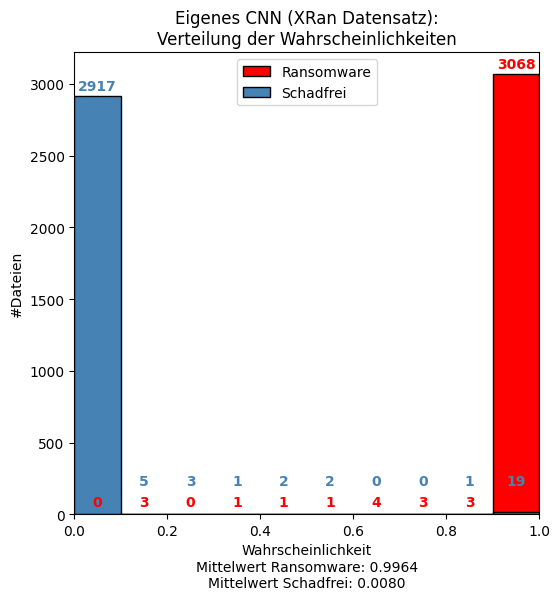

In [45]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'Eigenes CNN (XRan Datensatz):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

for bar in ransom_bars:
    if bar.get_height() < 120:
        plt.text(bar.get_x() + bar.get_width() / 2, 60, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 40, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 100:
        plt.text(bar.get_x() + bar.get_width() / 2, 200, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 40, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

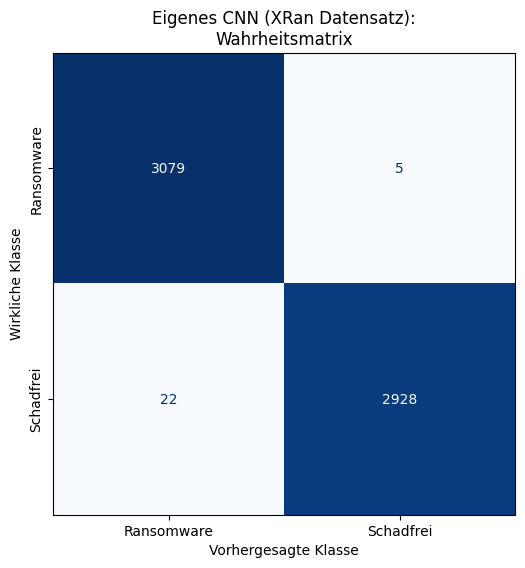

In [44]:
# Predict classes
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()
y_true_class = np.argmax(lables_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('Eigenes CNN (XRan Datensatz):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

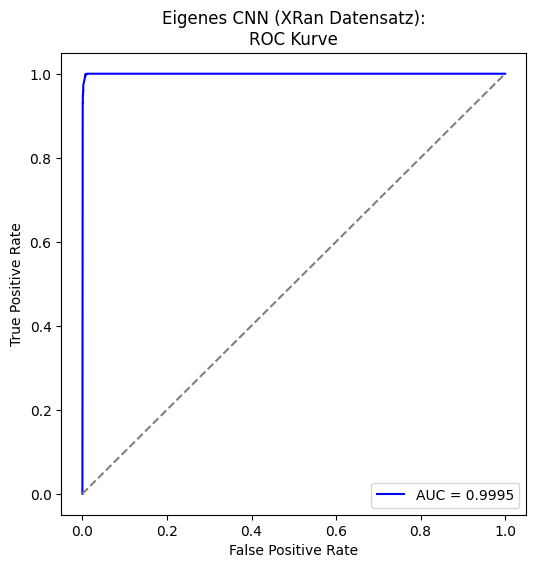

Bester Grenzwert: 0.6008099913597107


In [16]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_true_class, y_pred_prob)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eigenes CNN (XRan Datensatz):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [17]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)
mcc = (matthews_corrcoef(y_true_class, y_pred_class) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_true_class, y_pred_class, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9955
Recall (Sensitivity): 0.9984
Precision: 0.9929
F1-Score: 0.9956
AUC: 0.9995
MCC: 0.9955
Wertung: 0.9975

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9983    0.9925    0.9954      2950
  Ransomware     0.9929    0.9984    0.9956      3084

    accuracy                         0.9955      6034
   macro avg     0.9956    0.9955    0.9955      6034
weighted avg     0.9955    0.9955    0.9955      6034



# PE-Header Dataset

In [18]:
# Load the CSV file
pe_df = pd.read_csv('../datasets/peheaders/Ransomware_headers.csv')

X_train = np.array([])
y_train = np.array([])

# Iterate over the dataframe rows to create and save images
for index, row in pe_df.iterrows():
    # Extract the byte sequence (columns 5 to 1028)
    byte_sequence = row[4:].values
    byte_sequence = np.array(byte_sequence, dtype=np.uint8)
    label = row['GR']

    y_train = np.append(y_train, label)
    X_train = np.append(X_train, byte_sequence)

X_train = X_train.reshape(-1, 1024)

# Reshape data for CNN input
X_train = np.expand_dims(X_train, axis=-1)
# Convert labels to categorical
y_train = utils.to_categorical(y_train, num_classes=2)

# Split the dataset into training (60%) and temporary (40%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.4, random_state=42, stratify=y_train)

# Split the temporary dataset into validation (20%) and test (20%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (1294, 1024, 1) (1294, 2)
Validation set size: (431, 1024, 1) (431, 2)
Test set size: (432, 1024, 1) (432, 2)


### Train the Model

In [19]:
pe_input_shape = (X_train.shape[1], 1)

# Create the model
pe_model = create_model(pe_input_shape)
pe_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1022, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 511, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 509, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 252, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 126, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,095,810 (7.99 MB)

 Trainable params: 2,095,810 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
pe_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = pe_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100


2024-08-23 16:15:33.795369: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-23 16:15:33.896253: W external/local_tsl/tsl/framework/bfc_allocator.cc:363] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5856 - loss: 35.2379 - val_accuracy: 0.8399 - val_loss: 0.4303
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8940 - loss: 0.2918 - val_accuracy: 0.9258 - val_loss: 0.2440
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9449 - loss: 0.1687 - val_accuracy: 0.9490 - val_loss: 0.1804
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9690 - loss: 0.1031 - val_accuracy: 0.9397 - val_loss: 0.1898
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.0707 - val_accuracy: 0.9420 - val_loss: 0.1798
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9824 - loss: 0.0612 - val_accuracy: 0.9466 - val_loss: 0.1920
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9879 - loss: 0.0424 - val_accuracy: 0.9582 - val_loss: 0.1865
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9944 - loss: 0.0255 - val_accuracy: 0.9443 - val_loss: 0

In [21]:
pe_model.save('xran_pe_own.keras')

In [22]:
pe_model = models.load_model('xran_pe_own.keras', compile=True)
pe_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1022, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 511, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 509, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 252, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 126, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,287,432 (23.98 MB)

 Trainable params: 2,095,810 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,191,622 (15.99 MB)

In [23]:
# Predict probabilities
y_pred_prob = pe_model.predict(X_test)

# Get true labels
y_true_class = np.argmax(y_test, axis=1)
y_pred_prob = y_pred_prob[:, 1]

# Separate probabilities by true class
benign_probs = y_pred_prob[y_true_class == 0]
ransomware_probs = y_pred_prob[y_true_class == 1]

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


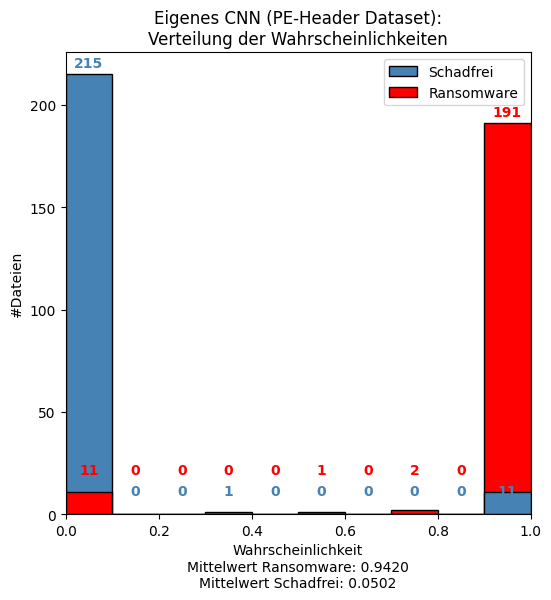

In [24]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Calculate histogram data
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
ransom_hist, _ = np.histogram(ransomware_probs, bins=bins)
benign_hist, _ = np.histogram(benign_probs, bins=bins)

# Determine which histogram has smaller values for each bin
smaller_on_top = ransom_hist < benign_hist

# Plot bars
x = (bins[:-1] + bins[1:]) / 2  # Center of each bin
width = np.diff(bins)

for i in range(len(x)):
    if smaller_on_top[i]:
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
    else:
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')

plt.title('Eigenes CNN (PE-Header Dataset):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

# Add text labels
for i, (ransom_count, benign_count) in enumerate(zip(ransom_hist, benign_hist)):
    if ransom_count < 60:
        plt.text(x[i], 18, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    else:
        plt.text(x[i], ransom_count + 2, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    
    if benign_count < 50:
        plt.text(x[i], 8, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')
    else:
        plt.text(x[i], benign_count + 2, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

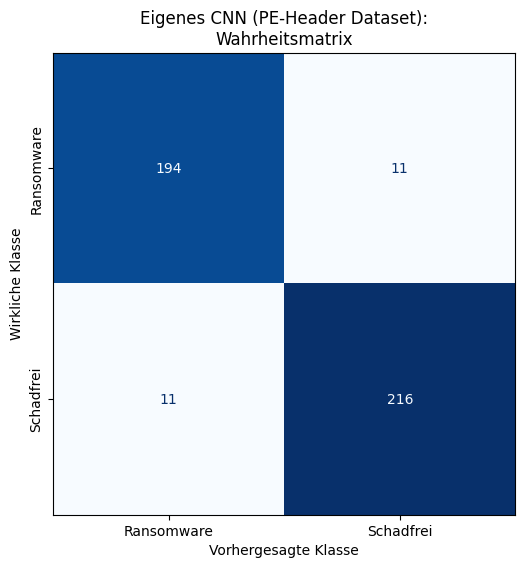

In [25]:
# Predict classes
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()
y_true_class = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_class, y_pred_class)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('Eigenes CNN (PE-Header Dataset):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

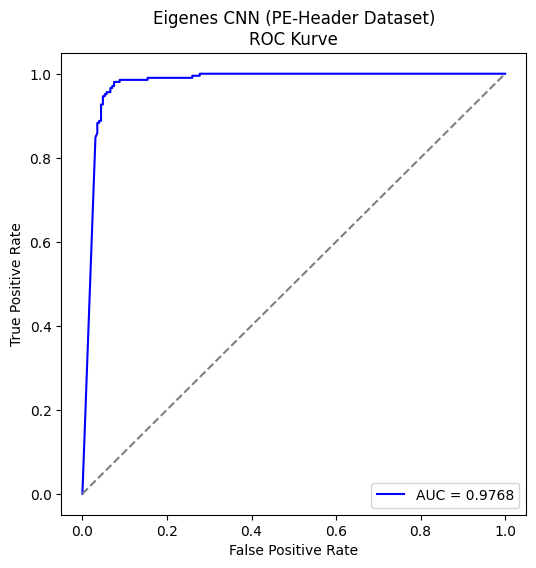

Bester Grenzwert: 0.00011934965004911646


In [26]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_true_class, y_pred_prob)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eigenes CNN (PE-Header Dataset)\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [27]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)
mcc = (matthews_corrcoef(y_true_class, y_pred_class) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_true_class, y_pred_class, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9491
Recall (Sensitivity): 0.9463
Precision: 0.9463
F1-Score: 0.9463
AUC: 0.9768
MCC: 0.9489
Wertung: 0.9505

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9515    0.9515    0.9515       227
  Ransomware     0.9463    0.9463    0.9463       205

    accuracy                         0.9491       432
   macro avg     0.9489    0.9489    0.9489       432
weighted avg     0.9491    0.9491    0.9491       432



# Ransomware Dataset 2016

In [28]:
# Load the data
rd_data = pd.read_csv('../datasets/ransomwaredataset2016/RansomwareData.csv', low_memory=False, header=None)

# Shuffle the dataset
rd_data_df = rd_data.sample(frac=1).reset_index(drop=True)
rd_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,30960,30961,30962,30963,30964,30965,30966,30967,30968,30969
0,21145,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20565,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20154,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11076,1,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20436,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
rd_data = rd_data_df.drop(1, axis=1).values
rd_lables = rd_data_df[1].values

# Reshape data for CNN input
rd_data = np.expand_dims(rd_data, axis=-1)

# Convert labels to categorical
rd_lables = utils.to_categorical(rd_lables, num_classes=2)

# Train/test/val 0.6/0.2/0.2 split
rd_data_train, rd_data_tmp, rd_lables_train, rd_lables_tmp = train_test_split(rd_data, rd_lables, test_size=0.4, random_state=42)
rd_data_val, rd_data_test, rd_lables_val, rd_lables_test = train_test_split(rd_data_tmp, rd_lables_tmp, test_size=0.5, random_state=42)

# Display shapes of the datasets
print(f'Train: {rd_data_train.shape}, {rd_lables_train.shape}')
print(f'Validation: {rd_data_val.shape}, {rd_lables_val.shape}')
print(f'Test: {rd_data_test.shape}, {rd_lables_test.shape}')

Train: (914, 30969, 1), (914, 2)
Validation: (305, 30969, 1), (305, 2)
Test: (305, 30969, 1), (305, 2)


In [30]:
input_shape = (rd_data_train.shape[1], 1)

# Create the model
rd_model = create_model(input_shape)
rd_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 30967, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 15483, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15481, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 7740, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 7738, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 3869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 495232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    63,389,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,421,122 (241.93 MB)

 Trainable params: 63,421,122 (241.93 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Train the model
rd_model.fit(rd_data_train, rd_lables_train, epochs=100, batch_size=32, validation_data=(rd_data_val, rd_lables_val))

# Evaluate the model
loss, accuracy = rd_model.evaluate(rd_data_val, rd_lables_val)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.6450 - loss: 23.6373 - val_accuracy: 0.8885 - val_loss: 0.2978
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9426 - loss: 0.1432 - val_accuracy: 0.9869 - val_loss: 0.0896
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9950 - loss: 0.0215 - val_accuracy: 0.9934 - val_loss: 0.0361
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9934 - val_loss: 0.0281
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9934 - val_loss: 0.0245
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9934 - val_loss: 0.0240
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9934 - val_loss: 0.0205
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 6.3860e-04 - va

In [32]:
rd_model.save('xran_rd_own.keras')

In [33]:
rd_model = models.load_model('xran_rd_own.keras', compile=True)
rd_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 30967, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 15483, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 15481, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 7740, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 7738, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 3869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 495232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    63,389,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,263,368 (725.80 MB)

 Trainable params: 63,421,122 (241.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 126,842,246 (483.86 MB)

In [34]:
# Predict probabilities
y_pred_prob = rd_model.predict(rd_data_test)

# Get true labels
y_true_class = np.argmax(rd_lables_test, axis=1)
y_pred_prob = y_pred_prob[:, 1]

# Separate probabilities by true class
benign_probs = y_pred_prob[y_true_class == 0]
ransomware_probs = y_pred_prob[y_true_class == 1]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


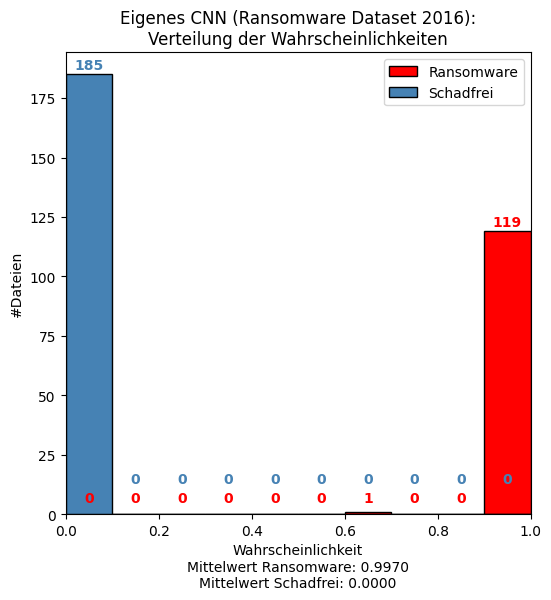

In [40]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'Eigenes CNN (Ransomware Dataset 2016):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

for bar in ransom_bars:
    if bar.get_height() < 30:
        plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 30:
        plt.text(bar.get_x() + bar.get_width() / 2, 13, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 2, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

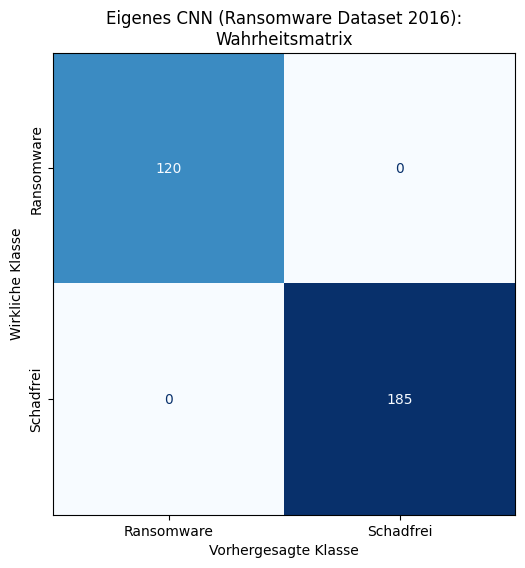

In [36]:
# Predict classes
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()
y_true_class = np.argmax(rd_lables_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('Eigenes CNN (Ransomware Dataset 2016):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

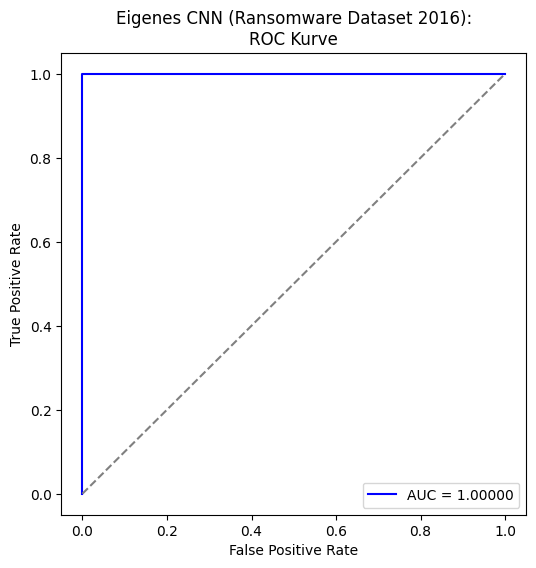

Bester Grenzwert: 0.6440861821174622


In [37]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_class, y_pred_prob)

# Calculate AUC
auc = roc_auc_score(y_true_class, y_pred_prob)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.5f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Eigenes CNN (Ransomware Dataset 2016):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [38]:
# Calculate and display classification metrics
accuracy = accuracy_score(y_true_class, y_pred_class)
recall = recall_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class)
f1 = f1_score(y_true_class, y_pred_class)
mcc = (matthews_corrcoef(y_true_class, y_pred_class) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(y_true_class, y_pred_class, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 1.0000
Recall (Sensitivity): 1.0000
Precision: 1.0000
F1-Score: 1.0000
AUC: 1.0000
MCC: 1.0000
Wertung: 1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     1.0000    1.0000    1.0000       185
  Ransomware     1.0000    1.0000    1.0000       120

    accuracy                         1.0000       305
   macro avg     1.0000    1.0000    1.0000       305
weighted avg     1.0000    1.0000    1.0000       305

